# English Premier League Network Analysis: Team Similarities and Rivalries

This notebook explores the structure of the English Premier League (EPL) through network analysis, focusing on team similarities based on performance metrics and identifying potential rivalries through aggressive play. We will specifically compare specific seasons with a broader range of seasons to observe evolving patterns.

The analysis leverages custom-built functions for data loading, network creation, centrality calculation, community detection, and result visualization, all designed with good programming practices and academic English.

In [5]:
import os
import sys
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root directory to the PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Import refactored utility functions
from src.data_utils import load_data
from src.pipeline import perform_epl_network_analysis # Our main analysis pipeline
from src.graph_utils import plot_epl_analysis_results # The new plotting function

# Ignore some common warnings for a cleaner display during execution
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning) # For newer pandas and networkx versions

## 1. Load the dataset

In [6]:
csv_file_path = '../data/epl_final.csv' # Adjust path as necessary for your environment
epl_df = load_data(csv_file_path)

if epl_df is None:
    print("Data loading failed. Exiting analysis.")

Data successfully loaded from: ../data/epl_final.csv
Loaded dataset shape: (9380, 22)


## 2. Analysis Scenarios
We will perform network analysis for specific seasons (2014/15 and 2015/16) and a broader range of seasons (2012/13 to 2017/18). For each scenario, we will analyze similarities in different aspects of team performance:
    
* **Similarity in Strength (based on 'goals' metric):** Identifies communities of teams with comparable goal-scoring performance. We filter by `goals_diff_norm_abs <= 0.3` (low difference), meaning `thresholds_for_analysis=[0.3]` and `keep_above_threshold=False`.
* **Similarity in Style (Aggressiveness):** Identifies communities of teams with similar levels of aggressiveness. We filter by `aggressiveness_diff_norm_abs <= 0.3`, meaning `thresholds_for_analysis=[0.3]` and `keep_above_threshold=False`.
* **Similarity in Control (Possession):** Identifies communities of teams with comparable ball possession styles. We filter by `poss_diff_norm_abs <= 0.3`, meaning `thresholds_for_analysis=[0.3]` and `keep_above_threshold=False`.
These thresholds are chosen to capture a reasonable degree of similarity (within 30% normalized difference).
   

### 2.1 Analysis for Specific Seasons

In [7]:
# --- 2014/15 Season: Similarity in Strength, Style and Control (Goals, Aggressiveness and Control) ---
print("\n\n#####################################################################")
print("### 2014/15 Season: Similarity in Strength, Style and Control ###")
print("#####################################################################")

df_2014_15_sim, desc_2014_15_sim, points_2014_15_sim = perform_epl_network_analysis(
    epl_df=epl_df,
    analysis_season='2014/15',
    metrics_to_analyze=['goals', 'aggressiveness', 'control'],
    thresholds_for_analysis=[3, 5, 4],
    keep_above_threshold=False,
    community_resolution=1.0,
    use_normalized_abs_diff_for_filter=False
)


# --- 2015/16 Season: Similarity in Strength, Style and Control (Goals, Aggressiveness and Control) ---
print("\n\n#####################################################################")
print("### 2015/16 Season: Similarity in Strength, Style and Control ###")
print("#####################################################################")

df_2015_16_sim, desc_2015_16_sim, points_2015_16_sim = perform_epl_network_analysis(
    epl_df=epl_df,
    analysis_season='2015/16',
    metrics_to_analyze=['goals', 'aggressiveness', 'control'],
    thresholds_for_analysis=[3, 5, 4],
    keep_above_threshold=False,
    community_resolution=1.0,
    use_normalized_abs_diff_for_filter=False
)



#####################################################################
### 2014/15 Season: Similarity in Strength, Style and Control ###
#####################################################################

--- Starting EPL Network Analysis for season 2014/15 ---
Network created for season 2014/15 with 20 nodes and 380 edges.

--- Overall Network Properties (Initial Directed Graph) ---
Number of nodes: 20
Number of edges: 380
Network Density: 1.0000

--- Calculating Total Team Points across the provided data ---
Top 10 Teams by Total Points:
  Chelsea: 87 points
  Man City: 79 points
  Arsenal: 75 points
  Man United: 70 points
  Tottenham: 64 points
  Liverpool: 62 points
  Southampton: 60 points
  Swansea: 56 points
  Stoke: 54 points
  Crystal Palace: 48 points

--- Starting Unified Centrality and Community Analysis ---

### Analysis for Metric: 'goals' ###

--- Filtering graph for 'goals' with threshold 3 ---
Applying reciprocal filter for 'goals' with threshold 3 <= threshold on

### 2.2 Analysis for a Range of Seasons (2012/13 - 2017/18)



#####################################################################
### Season Range (2012/13 - 2017/18): Similarity in Strength, Style and Control ###
#####################################################################

--- Starting EPL Network Analysis for seasons from 2012/13 to 2017/18 ---
Network created for seasons from 2012/13 to 2017/18 with 30 nodes and 762 edges.

--- Overall Network Properties (Initial Directed Graph) ---
Number of nodes: 30
Number of edges: 762
Network Density: 0.8759

--- Calculating Total Team Points across the provided data ---
Top 10 Teams by Total Points:
  Man City: 487 points
  Chelsea: 457 points
  Man United: 439 points
  Tottenham: 438 points
  Arsenal: 436 points
  Liverpool: 418 points
  Everton: 339 points
  Southampton: 302 points
  West Ham: 282 points
  Stoke: 274 points

--- Starting Unified Centrality and Community Analysis ---

### Analysis for Metric: 'goals' ###

--- Filtering graph for 'goals' with threshold 0.08 ---
Applying rec

/Users/marcello/Documents/Università/Erasmus/CN/premier-league-complex-net/src/graph_utils.py:745: UserWarning: The palette list has more values (46) than needed (30), which may not be intended.
  sns.scatterplot(


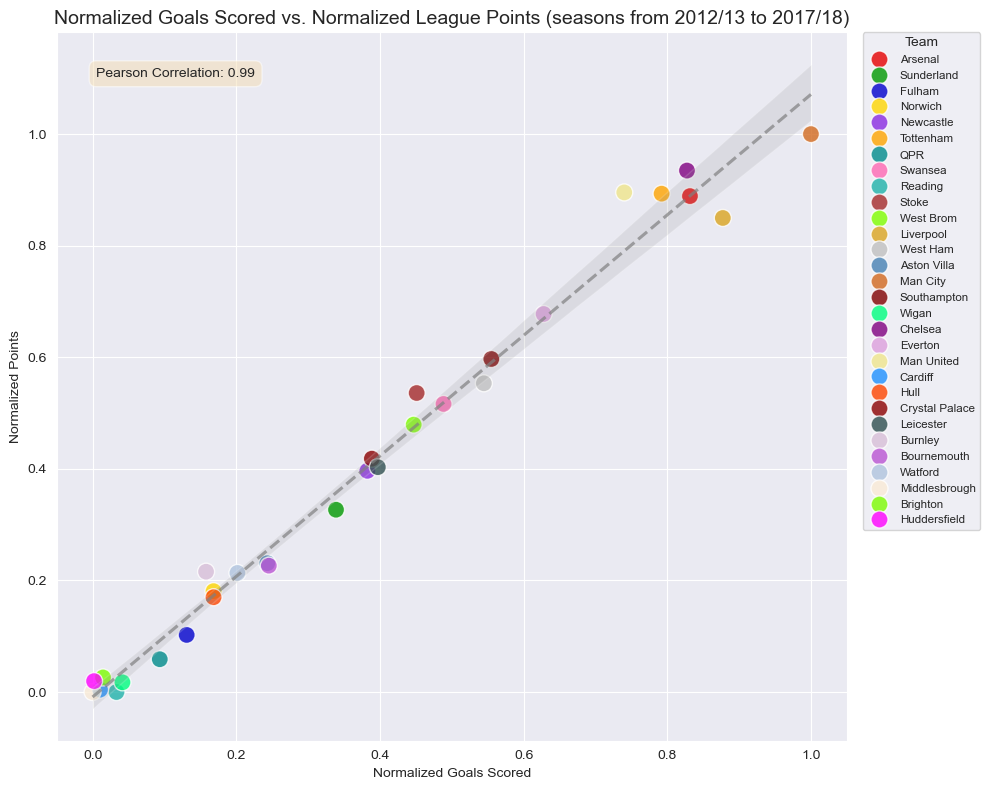

/Users/marcello/Documents/Università/Erasmus/CN/premier-league-complex-net/src/graph_utils.py:745: UserWarning: The palette list has more values (46) than needed (30), which may not be intended.
  sns.scatterplot(


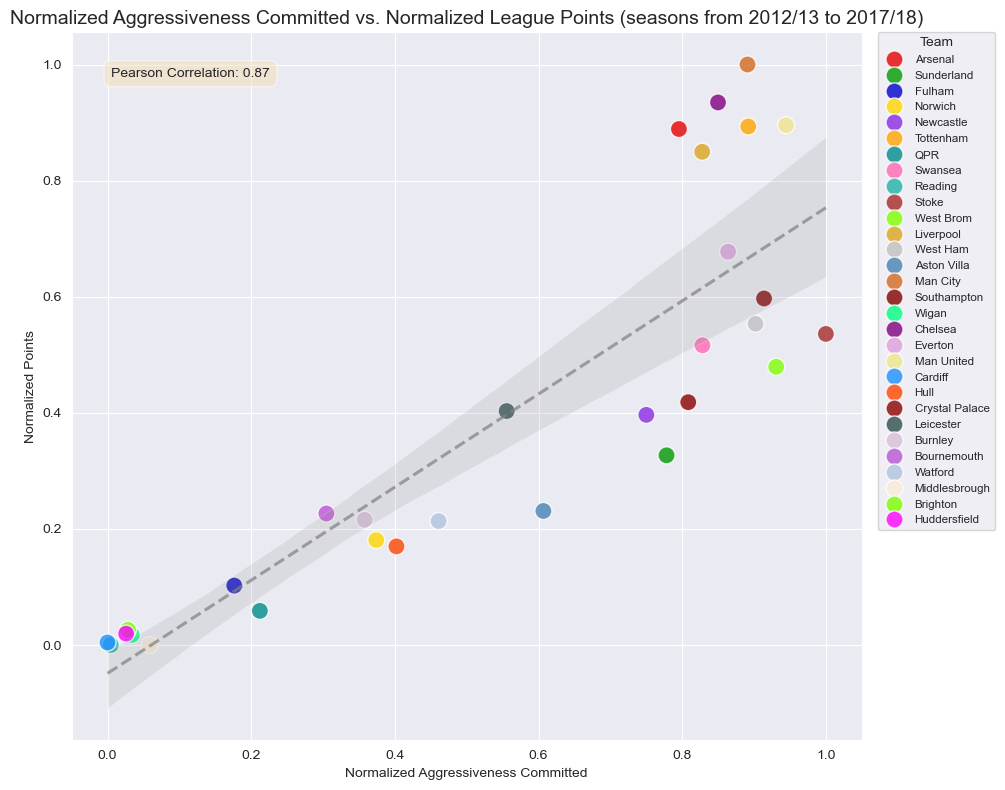

/Users/marcello/Documents/Università/Erasmus/CN/premier-league-complex-net/src/graph_utils.py:745: UserWarning: The palette list has more values (46) than needed (30), which may not be intended.
  sns.scatterplot(


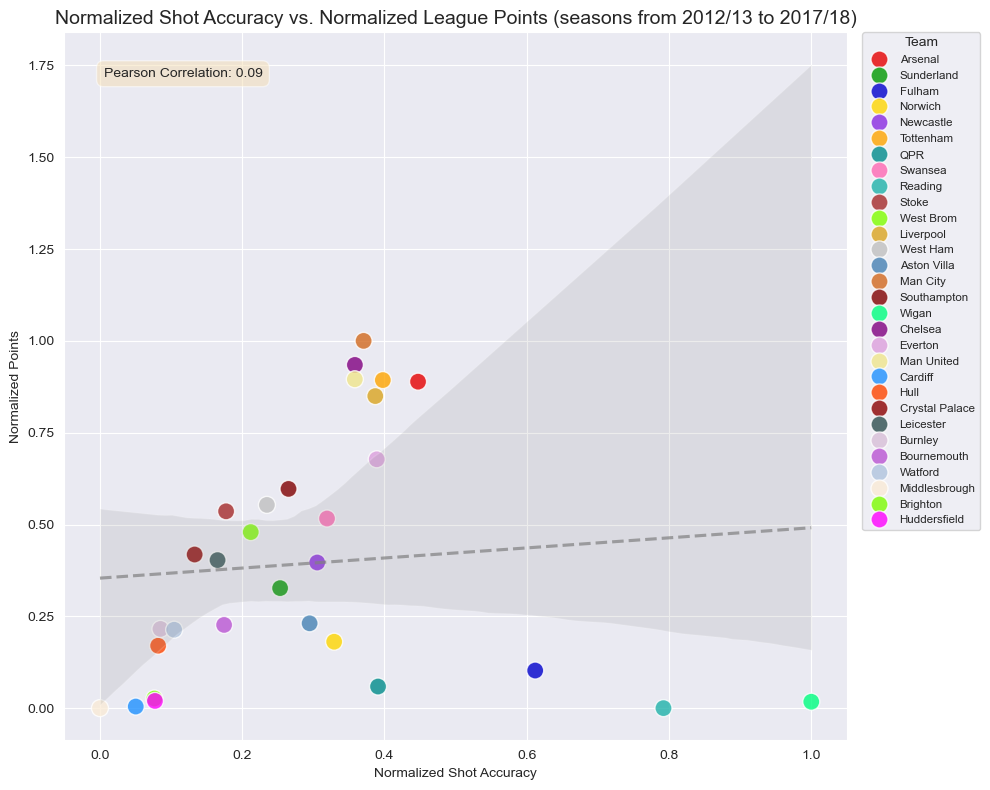

/Users/marcello/Documents/Università/Erasmus/CN/premier-league-complex-net/src/graph_utils.py:745: UserWarning: The palette list has more values (46) than needed (30), which may not be intended.
  sns.scatterplot(


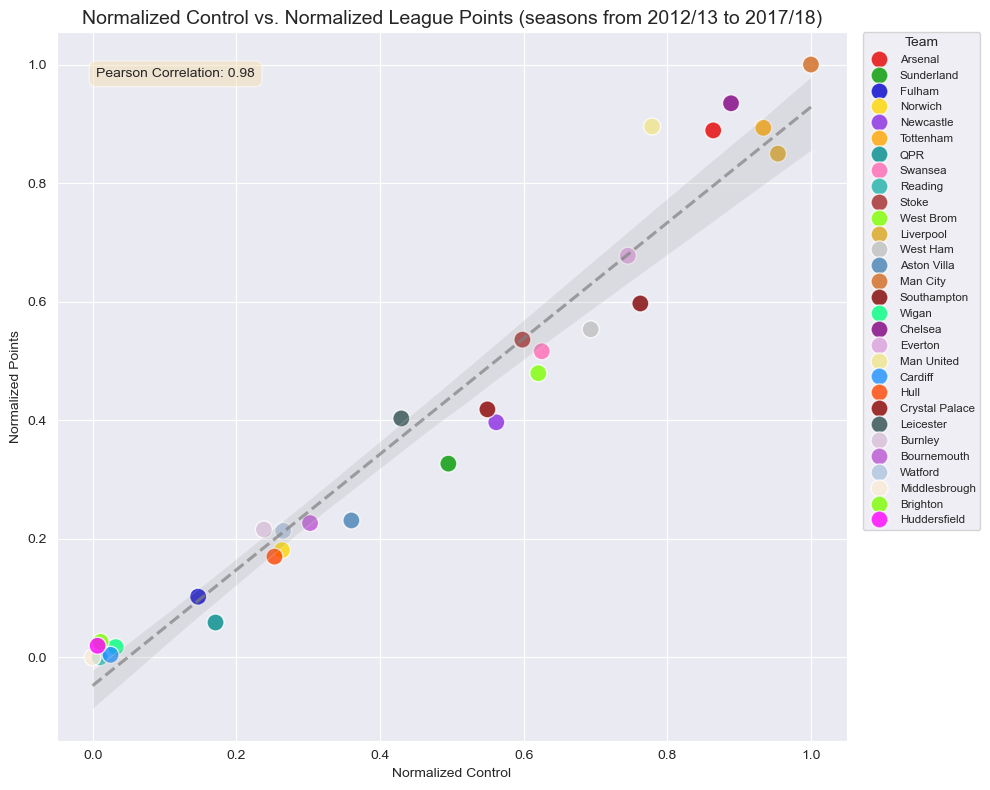

Metric Ratios vs. Normalized Points Plots generated successfully.


In [8]:
# --- Season Range (2012/13 - 2017/18): Similarity in Strength, Style and Control ---
print("\n\n#####################################################################")
print("### Season Range (2012/13 - 2017/18): Similarity in Strength, Style and Control ###")
print("#####################################################################")

# ONE SINGLE CALL to perform_epl_network_analysis
# This function will now return a dict containing ALL results, including df_for_scope, description, and league_points
df_2012_18_sim, desc_2012_18_sim, points_2012_18_sim = perform_epl_network_analysis(
    epl_df=epl_df, # Assuming epl_df is loaded elsewhere
    network_start_year=2012,
    network_end_year=2018,
    metrics_to_analyze=['goals', 'aggressiveness', 'control'],
    thresholds_for_analysis=[0.08, 0.15, 0.13],
    keep_above_threshold=False,
    community_resolution=1.0,
    use_normalized_abs_diff_for_filter=True
)

if df_2012_18_sim is not None and desc_2012_18_sim is not None and points_2012_18_sim is not None:
    plot_epl_analysis_results(
        epl_df=df_2012_18_sim,
        scope_description=desc_2012_18_sim,
)

## 3. Interpretation and Discussion

After running the code blocks above, observe the output, particularly focusing on:

### 3.1 Team Similarity Communities (Strength - Goals)

* **Specific Seasons (2014/15 vs. 2015/16):** Pay attention to which teams cluster together based on 'goals'. Do the traditional "Big 6" (Arsenal, Chelsea, Liverpool, Manchester City, Manchester United, Tottenham Hotspur) form distinct, high-performing communities, or are they spread across various groups? For the 2015/16 season, observe where Leicester City (the champions) falls. Do they cluster with other traditionally strong teams, or do they form a smaller, more isolated community, perhaps indicating their unique and highly efficient goal-scoring profile for that season?

* **Season Range (2012/13 - 2017/18):** How does the community structure based on 'goals' change when considering multiple seasons? Are there teams that consistently group together over this period, suggesting a stable level of strength? Do teams shift communities over time, indicating changes in their performance consistency or style?

### 3.2 Divergence/Rivalry Communities (Aggressiveness Differences)

* **Specific Seasons (2014/15 vs. 2015/16):** In these scenarios, communities are formed by teams with *highly different* levels of aggressiveness. This can represent 'clashes of styles' or distinct tactical approaches.
    * Observe the composition of these communities across both seasons. Are there consistent groups of teams that play very differently aggressively?
    * Do new rivalries or contrasting styles emerge prominently in the 2015/16 season that weren't as visible in 2014/15?
    * Consider if teams that are often seen as rivals in the league (e.g., Manchester United vs. Liverpool, Arsenal vs. Tottenham) appear in different communities based on their aggressive profiles.

* **Season Range (2012/13 - 2017/18):** How do rivalry patterns evolve over the multi-season period? Are certain teams consistently found in communities indicating high divergence in aggressiveness, suggesting persistent stylistic clashes? This longer-term view can help identify more enduring 'rivalries' based on contrasting playstyles rather than just single-season anomalies.

By examining the changes in community membership and graph structures between these distinct periods and types of analysis, we can gain insights into how team performance and tactical approaches influenced their network relationships. The centrality measures will also provide insights into which teams were most influential or central within these specific similarity or rivalry networks.